In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd '../gdrive/MyDrive/SSAC/3조'

/gdrive/.shortcut-targets-by-id/15_BxZVEQYCdGCGiQ5nexpWPc1cgHVe4w/3조


In [ ]:
import cv2
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

# DeepLab

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
def deeplab(image):
    input_image = Image.fromarray(image)
    input_image = input_image.convert("RGB")

    preprocess = transforms.Compose([
        # transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    # tensor to numpy array
    try: 
        mask = output_predictions.cpu().numpy()
    except:
        mask = output_predictions.numpy()

    # 1보다 크면 1, 0이면 0
    mask = np.where(mask>0, 1, 0)
    return mask

# 시각화 함수

In [ ]:
def show_img_compar5(img_1, img_2, img_3, img_4, img_5):
    f, ax = plt.subplots(1, 5, figsize=(10,10))
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[2].imshow(img_3)
    ax[3].imshow(img_4)
    ax[4].imshow(img_5)
    ax[0].axis('off') #hide the axis
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[4].axis('off')
    f.tight_layout()
    plt.show()

In [ ]:
from skimage.io import imread, imshow
from skimage.filters.rank import entropy
from skimage.morphology import disk

In [ ]:
def get_entropy(image_gray):
    scaled_entropy = image_gray / image_gray.max()
    entropy_image = entropy(scaled_entropy, disk(6))
    scaled_entropy = entropy_image / entropy_image.max()
    mask_ent = scaled_entropy > 0.8
    return mask_ent

In [ ]:
df = pd.read_csv('data/content.csv')

# DeepLab으로 배경/상품 색 추출

In [ ]:
# RGB 색상표
color_dict = {
    # 피부색 계열
    'Bisque' : [255, 228, 196],
    'Blanchedalmond': [255, 235, 205],
    'Ivory': [255, 255, 240],
    # 무채색 계열
    'Black': [0,0,0], 
    'Gray': [128, 128, 128],
    'White': [255, 255, 255],
    'Silver': [192, 192, 192],
    # 유채색 계열
    'Red': [255, 0, 0],
    'Maroon': [128, 0, 0],
    'Orange': [255, 165, 0],
    'Gold': [255, 215, 0],
    'Olive': [128, 128, 0],
    'Yellow': [255, 255, 0],
    'Chartreuse': [127, 255, 0],
    'Green': [0, 128, 0],
    'Lime': [0, 255, 0],
    'Teal': [0, 128, 128],
    'Aqua': [0, 255, 255],
    'Skyblue': [135, 206, 235],
    'Navy': [0, 0, 128],
    'Blue': [0, 0, 255],
    'Blueviolet': [138, 43, 226],
    'Purple': [128, 0, 128],
    'Magenta': [255, 0, 255],
    'Pink': [255, 192, 203],
    # 갈색 계열
    'Wheat': [245, 222, 179],
    'Saddlebrown': [139, 69, 19],
    'Tan': [210, 180, 140],
    'Linen': [250, 240, 230]
    }

def rgb_to_color(rgb, color_dict=color_dict):
    color_distance = [np.linalg.norm(np.array(rgb)-col) for col in color_dict.values()]
    return list(color_dict.keys())[np.argmin(color_distance)]

In [ ]:
def visualize_deeplab(cid):
    url = f'https://media.bunjang.co.kr/product/{cid}_...'
    image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
    image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
    # image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(image_hsv)
    # h_back = np.delete(h, (mask_2.reshape(-1)==1))
    
    mask = deeplab(image_rgb)

    image_nobg = image_rgb * mask[:, :, np.newaxis]
    image_bg = image_rgb * (1-mask)[:, :, np.newaxis]

    background_ratio = ((1-mask).sum())/(image_rgb.shape[0]*image_rgb.shape[1])

    bg_color = [np.delete(image_rgb[:,:,i], (mask.reshape(-1)==1)) for i in range(3)]
    nobg_color = [np.delete(image_rgb[:,:,i], (mask.reshape(-1)==0)) for i in range(3)]

    # 중앙값    
    rgb_bg = np.array([int(np.median(temp)) for temp in bg_color])
    rgb_nobg = np.array([int(np.median(temp)) for temp in nobg_color])
    
    # 최빈값
    rgb = []
    for i_t in bg_color:
        u_t, c_t = np.unique(i_t, axis=0, return_counts=True)
        rgb.append(u_t[np.argmax(c_t)])
    color_mode = rgb

    # # 시각화
    temp_bg = image_bg.copy()
    temp_nobg = image_nobg.copy()

    for i in range(3):
        temp_bg[:,:,i] = rgb_bg[i]
        temp_nobg[:,:,i] = rgb_nobg[i]
        
    show_img_compar5(image_rgb, image_bg, temp_bg, image_nobg, temp_nobg)

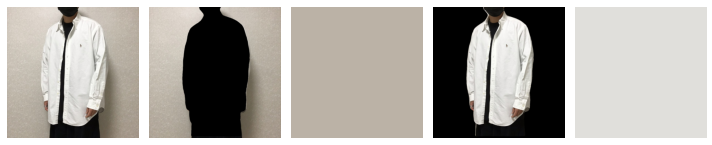

In [ ]:
visualize_deeplab(77262424)

In [ ]:
def get_image_feature(cid):
    url = f'https://media.bunjang.co.kr/product/{cid}_...'
    image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
    image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
    # image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = deeplab(image_rgb)

    image_nobg = image_rgb * mask[:, :, np.newaxis]
    image_bg = image_rgb * (1-mask)[:, :, np.newaxis]

    background_ratio = ((1-mask).sum())/(image_rgb.shape[0]*image_rgb.shape[1])

    bg_color = [np.delete(image_rgb[:,:,i], (mask.reshape(-1)==1)) for i in range(3)]
    nobg_color = [np.delete(image_rgb[:,:,i], (mask.reshape(-1)==0)) for i in range(3)]

    # 배경/상품 색상 추출    
    rgb_bg = np.array([int(np.median(temp)) for temp in bg_color])
    color_bg = rgb_to_color(rgb_bg)

    rgb_nobg = np.array([int(np.median(temp)) for temp in nobg_color])
    color_nobg = rgb_to_color(rgb_nobg)


    # 노이즈 계산
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    bg_gray = image_gray * (1-mask)
    bg_ent = get_entropy(bg_gray)
    bg_mask = bg_ent>0.8
    bg_noise = bg_ent.sum() / (1-mask).sum()

    nobg_gray = image_gray * mask
    nobg_ent = get_entropy(nobg_gray)
    nobg_mask = nobg_ent > 0.8
    nobg_noise = nobg_ent.sum() / mask.sum()

    # HSV -> 사람 구분
    upper_human = (20, 150, 200)
    lower_human = (0, 50, 60)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    human_mask = cv2.inRange(image_hsv, lower_human, upper_human)
    _,counts = np.unique(mask * human_mask, return_counts=True)
    human_ratio = counts[1] / mask.sum()

    show_img_compar5(image, image_nobg, image_bg, image_gray*bg_mask,image_gray * nobg_mask)

    image_dict = {"content_id": cid, 'background_ratio': background_ratio,
     'bg_rgb': rgb_bg, "nobg_rgb": rgb_nobg, 
     "bg_color": color_bg, "nobg_color": color_nobg, 
     "bg_noise": bg_noise, "nobg_noise": nobg_noise,
     "human_ratio": human_ratio}

    return image_dict

# 노이즈

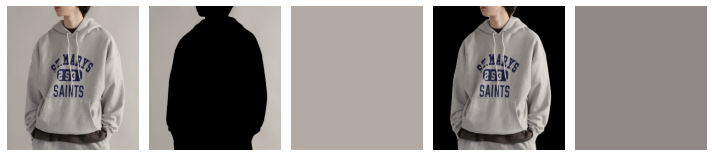

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


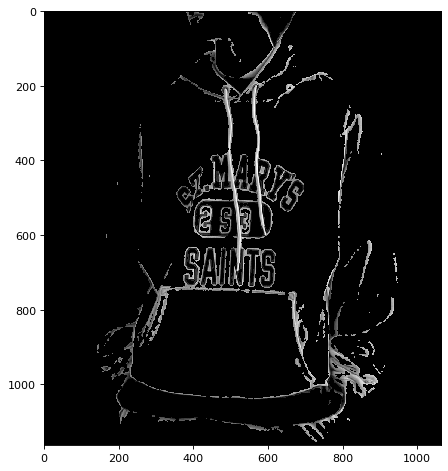

In [ ]:
image_rgb, image_bg, image_nobg, mask  = visualize_deeplab(169592470)
shawl_gray = rgb2gray(image_rgb) * mask
scaled_entropy = shawl_gray / shawl_gray.max()
entropy_image = entropy(scaled_entropy, disk(6))
scaled_entropy = entropy_image / entropy_image.max()
mask_ent = scaled_entropy > 0.8
# plt.figure(num=None, figsize=(8, 6), dpi=80)
# imshow(shawl_gray * mask_ent * mask, cmap = 'gray');
plt.figure(num=None, figsize=(8, 6), dpi=80)
imshow(shawl_gray * mask_ent, cmap = 'gray');